In [1]:
# # Run this and then restart the kernel at the start of each session to install
# # 'teotil3' in development mode
# !pip install -e /home/jovyan/projects/teotil3/

In [2]:
import glob
import os

import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
import teotil3 as teo
from tqdm.notebook import tqdm

plt.style.use("ggplot")

# Task 2.7: Improve workflow for non-agricultural diffuse inputs

## Part D: Explore background inputs

The notebooks for parts A to C developed a new workflow for non-agricultural diffuse inputs. The main changes are:

 * Updated nutrient coefficients for "skog" and "fjell" areas based on the 2019 "1000 Lakes" survey
 * Concentration-based urban coefficients from [Åstebøl et al. (2012)](https://www.miljodirektoratet.no/sharepoint/downloaditem?id=01FM3LD2XYMQWENJOBOVEL2YIHX3PUTEYP)
 * Area-based SS coefficients from [Bogen (1996)](https://www.researchgate.net/publication/237813476_Erosion_and_Sediment_Yield_in_Norwegian_Rivers)
 * Space- and time-varying atmospheric deposition of N to lakes based on data from EMEP
 
In addition, all key datasets have been migrated to the `teotil3` schema in JupyterHub's PostGIS database, which streamlines the workflow for generating model input files.

This notebook explores the background inputs generated by the new model, including comparison to the inputs used by TEOTIL2.

## 1. Generate input files for 1990 to 2021

I have added functions to `teo.io` to process the background datasets. The function `teo.io.make_input_file` wraps these functions and returns a complete input file. Eventually, this function will also handle processing for the point-source and agricultural inputs, but for now it just considers non-agricultural diffuse sources. The code below generates input files for the period from 1990 to 2021 and saves results as CSVs. These are then explored in the rest of the notebook to ensure the spatial and temporal changes are broadly sensible.

In [3]:
eng = nivapy.da.connect_postgis()

Connection successful.


In [4]:
regine_year = 2022
nve_data_year = 2022
st_yr, end_yr = 1990, 2021
out_csv_fold = r"/home/jovyan/shared/teotil3/annual_input_data"

In [5]:
# %%time

# years = range(st_yr, end_yr + 1)
# for year in tqdm(years):
#     gdf = teo.io.make_input_file(
#         year,
#         nve_data_year,
#         eng,
#         out_csv_fold=out_csv_fold,
#         regine_year=2022,
#     )

## 2. Explore input files

### 2.1. Merge all data

In [6]:
# Merge all CSVs
df_list = []
search_path = os.path.join(out_csv_fold, "*.csv")
flist = glob.glob(search_path)
for fpath in flist:
    fname = os.path.split(fpath)[1]
    year = int(fname.split("_")[3])
    df = pd.read_csv(fpath)
    df["year"] = year
    df_list.append(df)

df = pd.concat(df_list, axis="rows")
df.head()

,regine,regine_down,a_cat_land_km2,runoff_mm/yr,q_cat_m3/s,trans_orig-totp,trans_orig-totn,ret_orig-totp,ret_orig-totn,wood_din_kg,...,urban_ton_kg,urban_tdp_kg,urban_tpp_kg,urban_toc_kg,urban_ss_kg,lake_din_kg,wood_ss_kg,upland_ss_kg,glacier_ss_kg,year
0,001.10,001.,1.16,330.479540,0.012148,1.000000,1.000000,0.000000,0.000000,19.027342,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.013921,1698.376024,0.000000,0.0,1991
1,001.1A1,001.,1.43,336.647859,0.015255,1.000000,1.000000,0.000000,0.000000,31.533247,...,0.000000,0.000000,0.000000,0.000000,0.000000,50.984363,2754.951242,119.988552,0.0,1991
2,001.1A20,001.1A1,0.34,245.783779,0.002648,1.000000,1.000000,0.000000,0.000000,5.042510,...,0.000000,0.000000,0.000000,0.000000,0.000000,38.819944,606.983457,0.000000,0.0,1991
3,001.1A2A,001.1A20,17.65,287.064066,0.160553,1.000000,1.000000,0.000000,0.000000,290.816641,...,41.550796,5.666018,3.777345,415.507960,3777.345092,128.328063,30061.491333,12151.720246,0.0,1991
4,001.1A2B,001.1A2A,41.30,295.367572,0.386553,0.114735,0.708605,0.885265,0.291395,576.496900,...,52.479831,7.156341,4.770894,524.798307,4770.893703,6912.591708,59596.788722,58520.775191,0.0,1991


### 2.2. Compare results for specific catchments

The code below performs the following comparison for specific regines:

 * Compares results for TOTN and TOTP to those from the old TEOTIL2 model
 * Plots time series from 1990 to 2021 for the new model to check patterns seem sensible
 
**Note:** The TEOTIL2 results use slightly different NVE discharge series, which introduces some noise, but this does not seem to be a major source of discrepancy compared to the difference in methodology.

In [7]:
def compare_regine_series(reg_id, df, comp_year):
    """ """
    # Get TEOTIL2 data
    url = f"https://raw.githubusercontent.com/NIVANorge/teotil2/main/data/norway_annual_input_data/input_data_{comp_year}.csv"
    teo2_df = pd.read_csv(url)
    cols = [
        "regine",
        "urban_tot-n_tonnes",
        "nat_diff_tot-n_tonnes",
        "urban_tot-p_tonnes",
        "nat_diff_tot-p_tonnes",
    ]
    teo2_df = teo2_df[cols]
    cols = [
        "regine",
        "urban_tot-n_tonnes",
        "natdiff_tot-n_tonnes",
        "urban_tot-p_tonnes",
        "natdiff_tot-p_tonnes",
    ]
    teo2_df.columns = cols
    teo2_df = teo2_df.query("regine == @reg_id").melt(id_vars=["regine"])
    teo2_df[["source", "par_unit"]] = teo2_df["variable"].str.split("_", 1, expand=True)
    del teo2_df["variable"], teo2_df["regine"]
    teo2_df["model"] = "old"

    # Get new data and aggregate to TEOTIL2 classes for TOTN and TOTP
    # NOTE: 'nat_diff' in TEOTIL2 inlcudes some background input from agriculture,
    # which are not yet included for TEOTIL3
    reg_df = df.query("(regine == @reg_id) and (year == @comp_year)").copy()
    reg_df["urban_tot-n_tonnes"] = (
        reg_df["urban_ton_kg"] + reg_df["urban_din_kg"]
    ) / 1000
    reg_df["urban_tot-p_tonnes"] = (
        reg_df["urban_tpp_kg"] + reg_df["urban_tdp_kg"]
    ) / 1000
    reg_df["natdiff_tot-n_tonnes"] = (
        reg_df["wood_totn_kg"] + reg_df["upland_totn_kg"] + reg_df["lake_din_kg"]
    ) / 1000
    reg_df["natdiff_tot-p_tonnes"] = (
        reg_df["wood_totp_kg"] + reg_df["upland_totp_kg"]
    ) / 1000

    reg_df = reg_df[cols].melt(id_vars=["regine"])
    reg_df[["source", "par_unit"]] = reg_df["variable"].str.split("_", 1, expand=True)
    del reg_df["variable"], reg_df["regine"]
    reg_df["model"] = "new"

    comp_df = pd.concat([reg_df, teo2_df], axis="rows")
    comp_df = comp_df[["model", "source", "par_unit", "value"]]

    display(comp_df.set_index(["model", "source", "par_unit"]).unstack("model"))

    sn.catplot(
        data=comp_df,
        x="model",
        y="value",
        col="par_unit",
        row="source",
        kind="bar",
        sharey=False,
        order=["old", "new"],
        height=3,
        aspect=1.5,
    )

    return comp_df


def summarise_regine_series(reg_id, df, comp_year, log_y=False):
    reg_df = df.query("regine == @reg_id").sort_values("year").copy()

    ignore_cols = [
        "regine",
        "regine_down",
        "a_cat_land_km2",
        "runoff_mm/yr",
        "q_cat_m3/s",
        "trans_orig-totp",
        "trans_orig-totn",
        "ret_orig-totp",
        "ret_orig-totn",
    ]
    reg_df.drop(ignore_cols, axis="columns", inplace=True)
    reg_df = reg_df.melt(id_vars=["year"])
    reg_df[["source", "par_unit"]] = reg_df["variable"].str.split("_", 1, expand=True)
    reg_df = reg_df[["source", "par_unit", "year", "value"]]

    # Ignore TOTN and TOTP for now, as not consistent
    reg_df = reg_df.query("par_unit not in ['totn_kg', 'totp_kg']")

    display(reg_df.groupby(["par_unit", "source"]).mean()[["value"]])

    g = sn.relplot(
        data=reg_df,
        x="year",
        y="value",
        col="par_unit",
        hue="source",
        col_wrap=3,
        kind="line",
        marker="o",
        facet_kws={"sharey": False, "sharex": True},
    )
    if log_y:
        g.set(yscale="log")

    return reg_df

#### 2.2.1. An urban-dominated catchment in Oslo

The new natural coefficients for this area are very similar to those used in the original model. However, the new urban coefficients from Åstebøl et al. (2012) yield substantially higher fluxes than the old model. Otherwise, the relative ordering of the inputs seems reasonable: `upland` is approximately an order of magnitude smaller than `woodland`, which is and order of magnitude smaller than `urban`.

value          
model                       new       old
source  par_unit                         
natdiff tot-n_tonnes   0.722798  0.794979
        tot-p_tonnes   0.013949  0.013985
urban   tot-n_tonnes  14.956221  2.396800
        tot-p_tonnes   1.495622  0.342400

value
par_unit source                
din_kg   lake         14.709053
         upland        7.722915
         urban      5788.167475
         wood         78.826214
ss_kg    glacier       0.000000
         upland    12944.451684
         urban    413440.533942
         wood       5975.500217
tdp_kg   upland        0.395513
         urban       620.160801
         wood          2.123686
toc_kg   upland     1998.382346
         urban     45478.458734
         wood      15990.103729
ton_kg   upland       49.210165
         urban      4547.845873
         wood        356.279499
tpp_kg   upland        0.749393
         urban       413.440534
         wood          6.371057

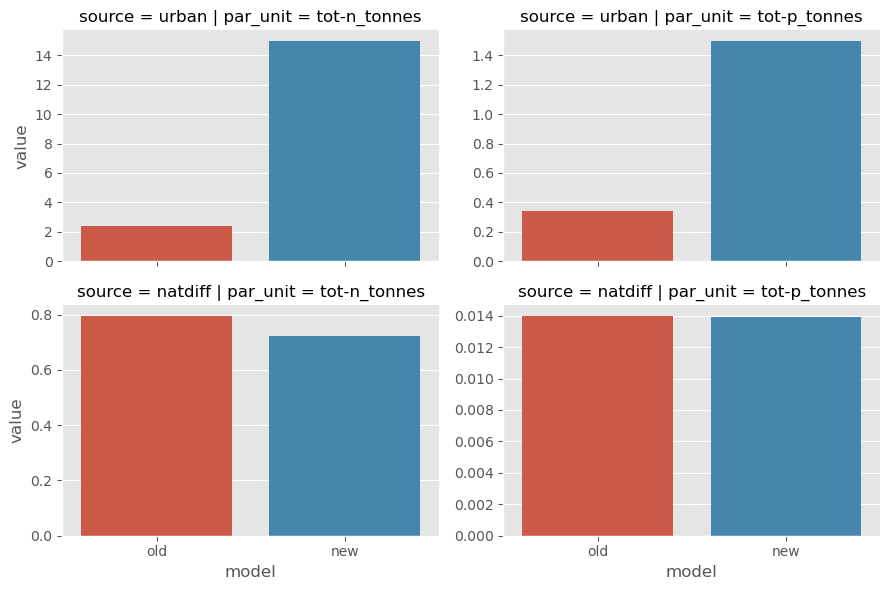

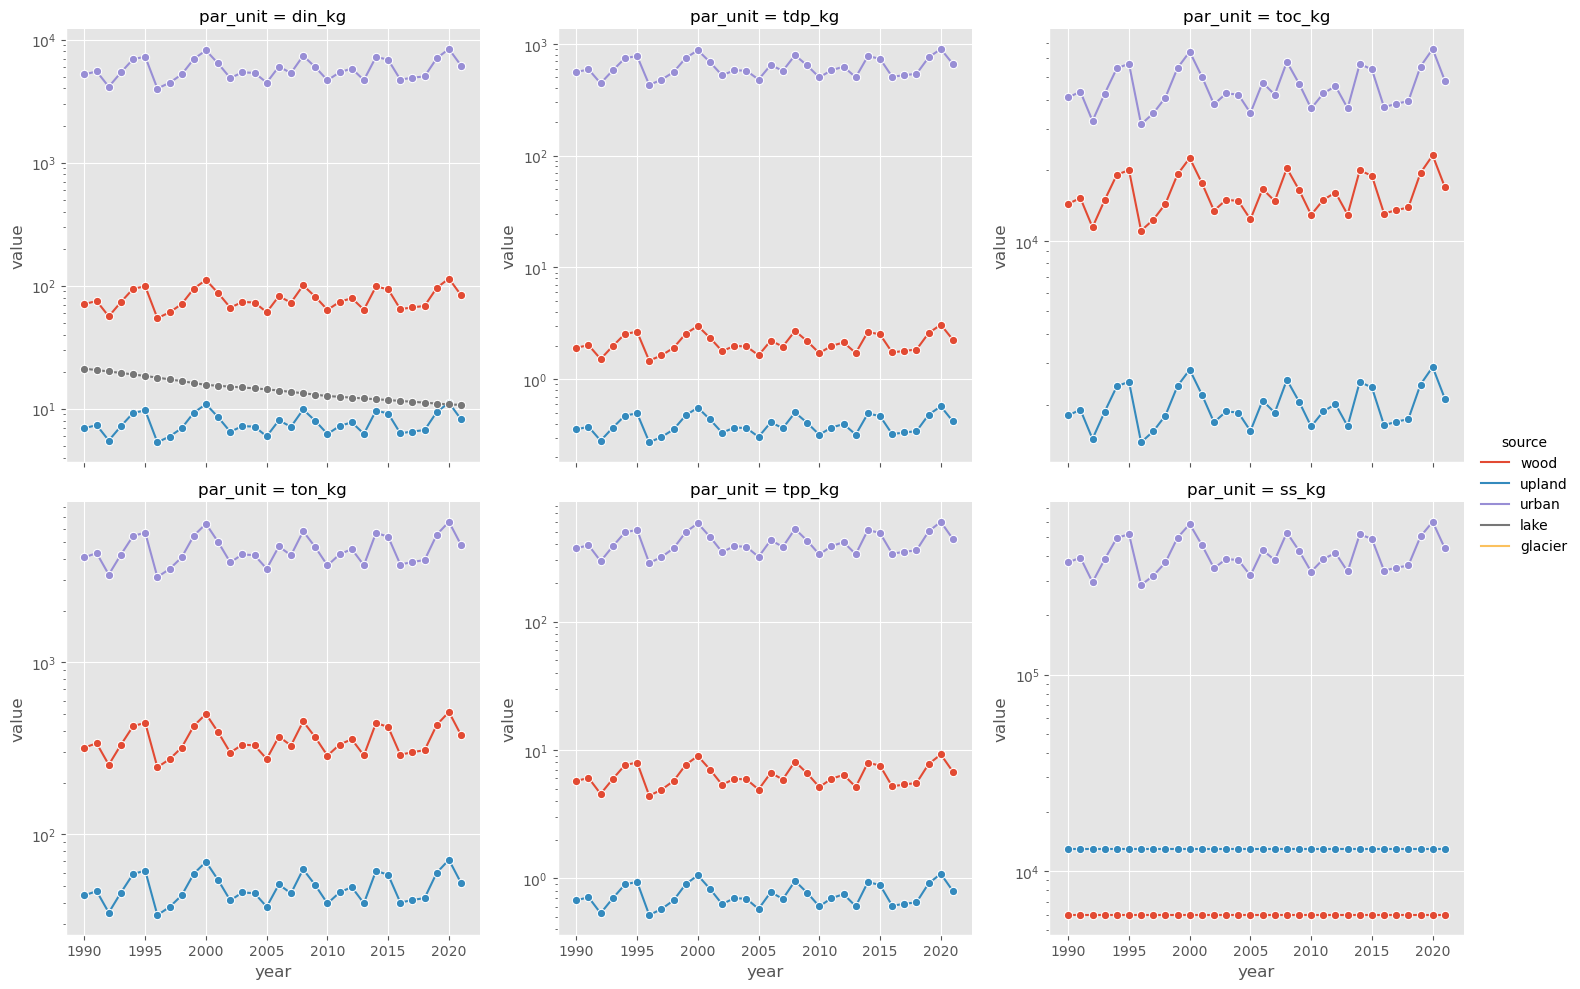

In [8]:
# Year to use for getting data from old model
comp_year = 2020

# Regine of interest
reg_id = "006.A1Z"

# Compare old vs. new
comp_df = compare_regine_series(reg_id, df, comp_year)

# Time series for new
reg_df = summarise_regine_series(reg_id, df, comp_year, log_y=True)

#### 2.2.2. A mountain catchment in Jotunheimen

The basic fluxes seem reasonable, but note that the new coefficients for woodland and upland based on the 2019 "1000 Lakes" survey are substantially lower than those used in the original model in this part of Norway. As a result, the new model predicts lower fluxes than TEOTIL2.

value          
model                      new       old
source  par_unit                        
natdiff tot-n_tonnes  0.960365  2.827065
        tot-p_tonnes  0.029399  0.068636
urban   tot-n_tonnes  0.000000  0.000000
        tot-p_tonnes  0.000000  0.000000

value
par_unit source                
din_kg   lake         55.923133
         upland      301.444351
         urban         0.000000
         wood          0.000000
ss_kg    glacier  126101.678623
         upland   212566.287738
         urban         0.000000
         wood          0.000000
tdp_kg   upland       16.294289
         urban         0.000000
         wood          0.000000
toc_kg   upland     6789.287187
         urban         0.000000
         wood          0.000000
ton_kg   upland      549.932262
         urban         0.000000
         wood          0.000000
tpp_kg   upland       10.862859
         urban         0.000000
         wood          0.000000

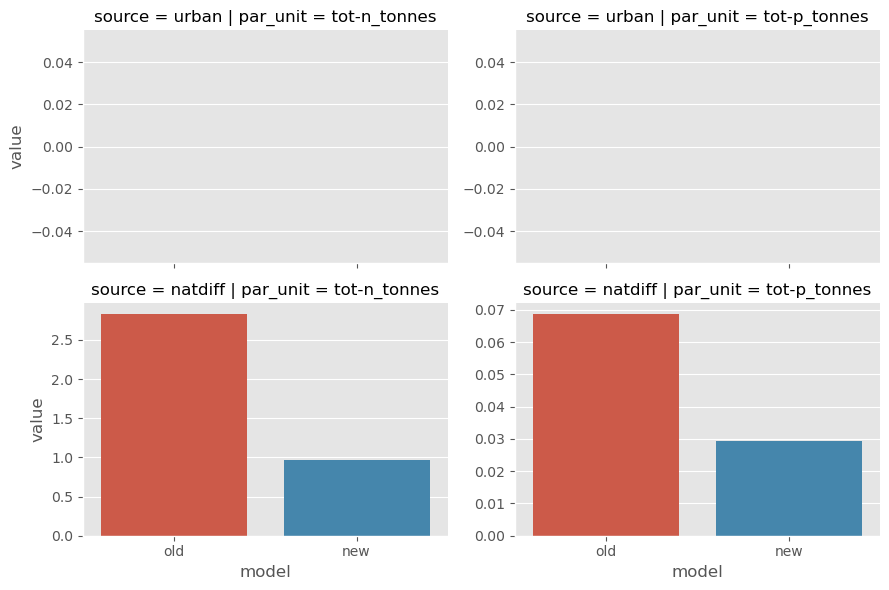

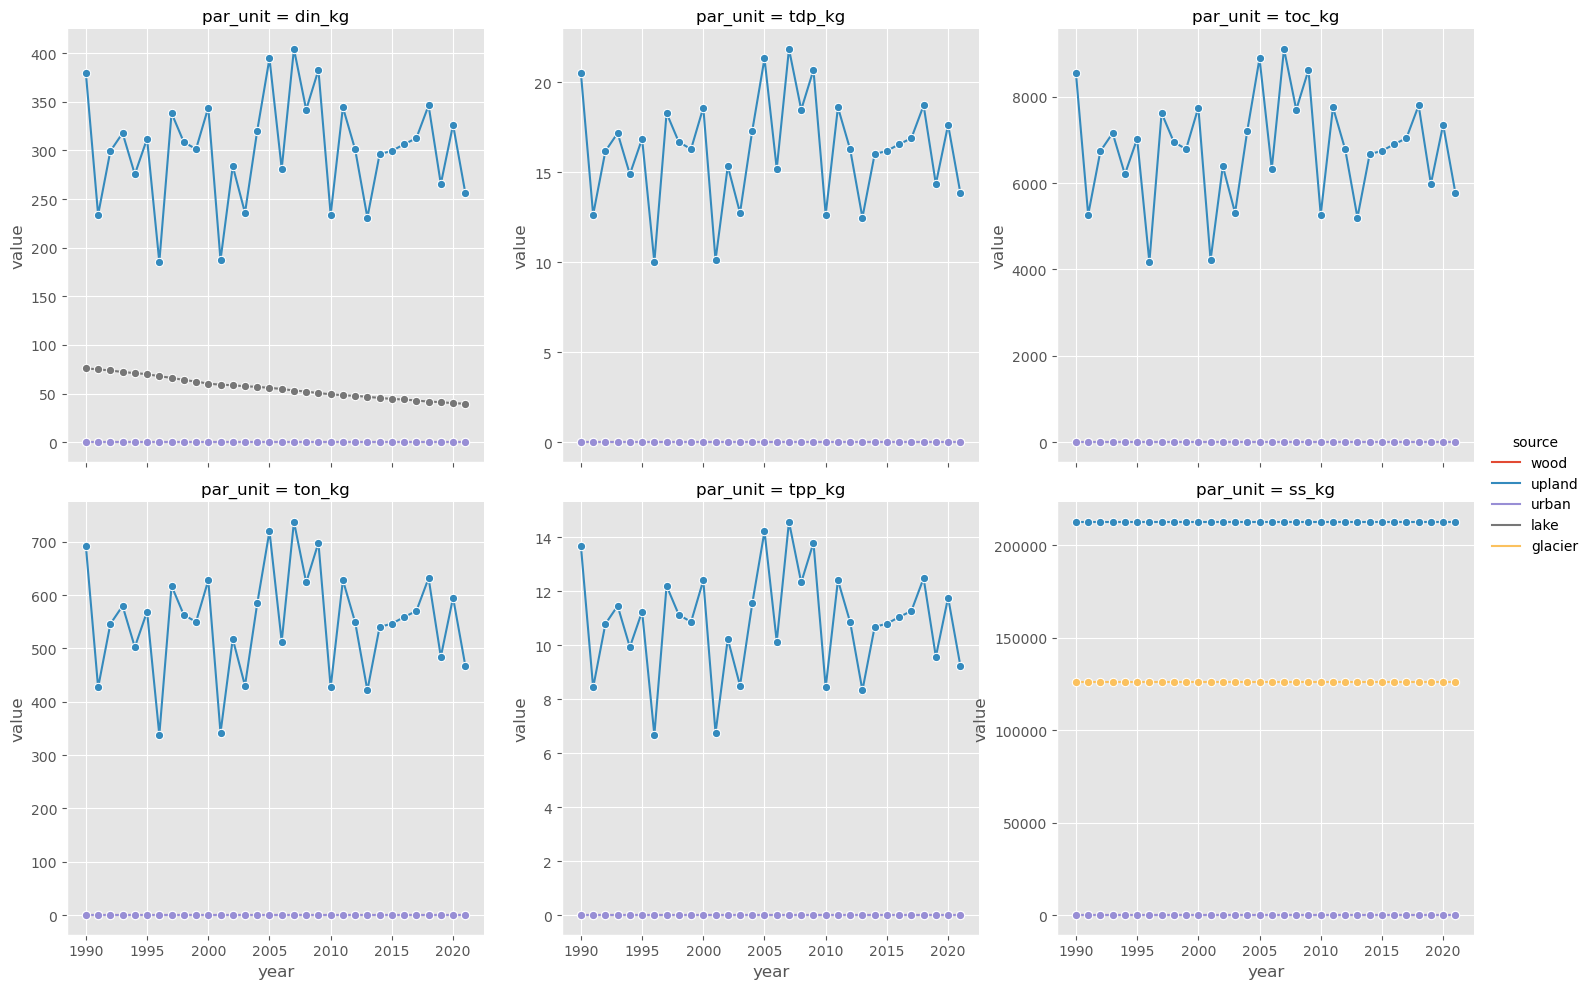

In [9]:
# Year to use for getting data from old model
comp_year = 2020

# Regine of interest
reg_id = "075.BC1B"

# Compare old vs. new
comp_df = compare_regine_series(reg_id, df, comp_year)

# Time series for new
reg_df = summarise_regine_series(reg_id, df, comp_year, log_y=False)

#### 2.2.3. An upland catchment in Finnmark

In this case, the new coefficients for `woodland` and `upland` are a bit smaller than those used in the old model, but the differences are not as large as in the southwest. Overall fluxes are broadly comparable. Note also that, for DIN, atmospheric deposition was the dominant source in 1990, but is now significantly lower than `upland` and roughly comparable to `woodland`, which is interesting.

value          
model                      new       old
source  par_unit                        
natdiff tot-n_tonnes  6.365912  9.024990
        tot-p_tonnes  0.128243  0.146526
urban   tot-n_tonnes  0.000000  0.000000
        tot-p_tonnes  0.000000  0.000000

value
par_unit source                
din_kg   lake        161.192398
         upland      161.396042
         urban         0.000000
         wood         93.877662
ss_kg    glacier       0.000000
         upland   904880.836175
         urban         0.000000
         wood      35543.969057
tdp_kg   upland       19.239263
         urban         0.000000
         wood          9.278606
toc_kg   upland    59855.485895
         urban         0.000000
         wood      30564.820135
ton_kg   upland     3082.557524
         urban         0.000000
         wood       1468.748768
tpp_kg   upland       45.960462
         urban         0.000000
         wood         24.015216

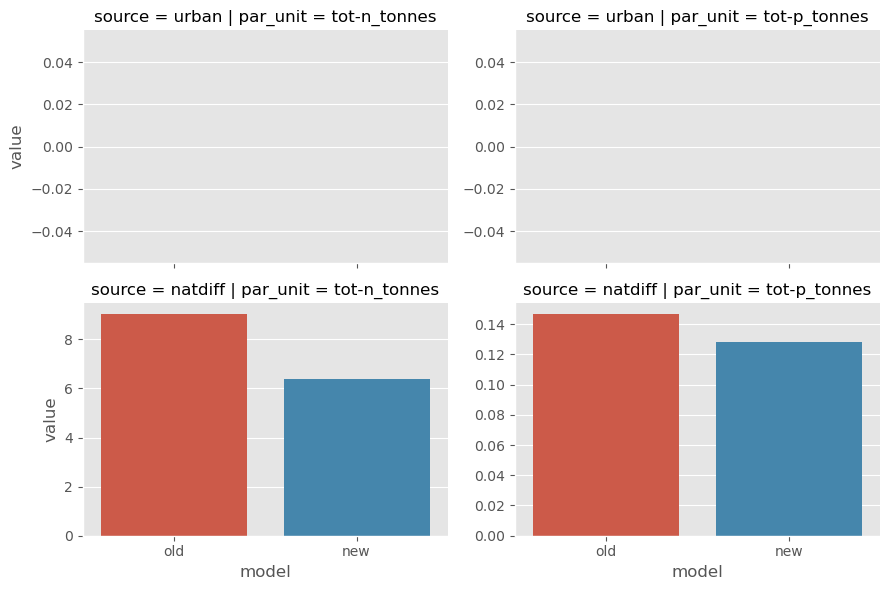

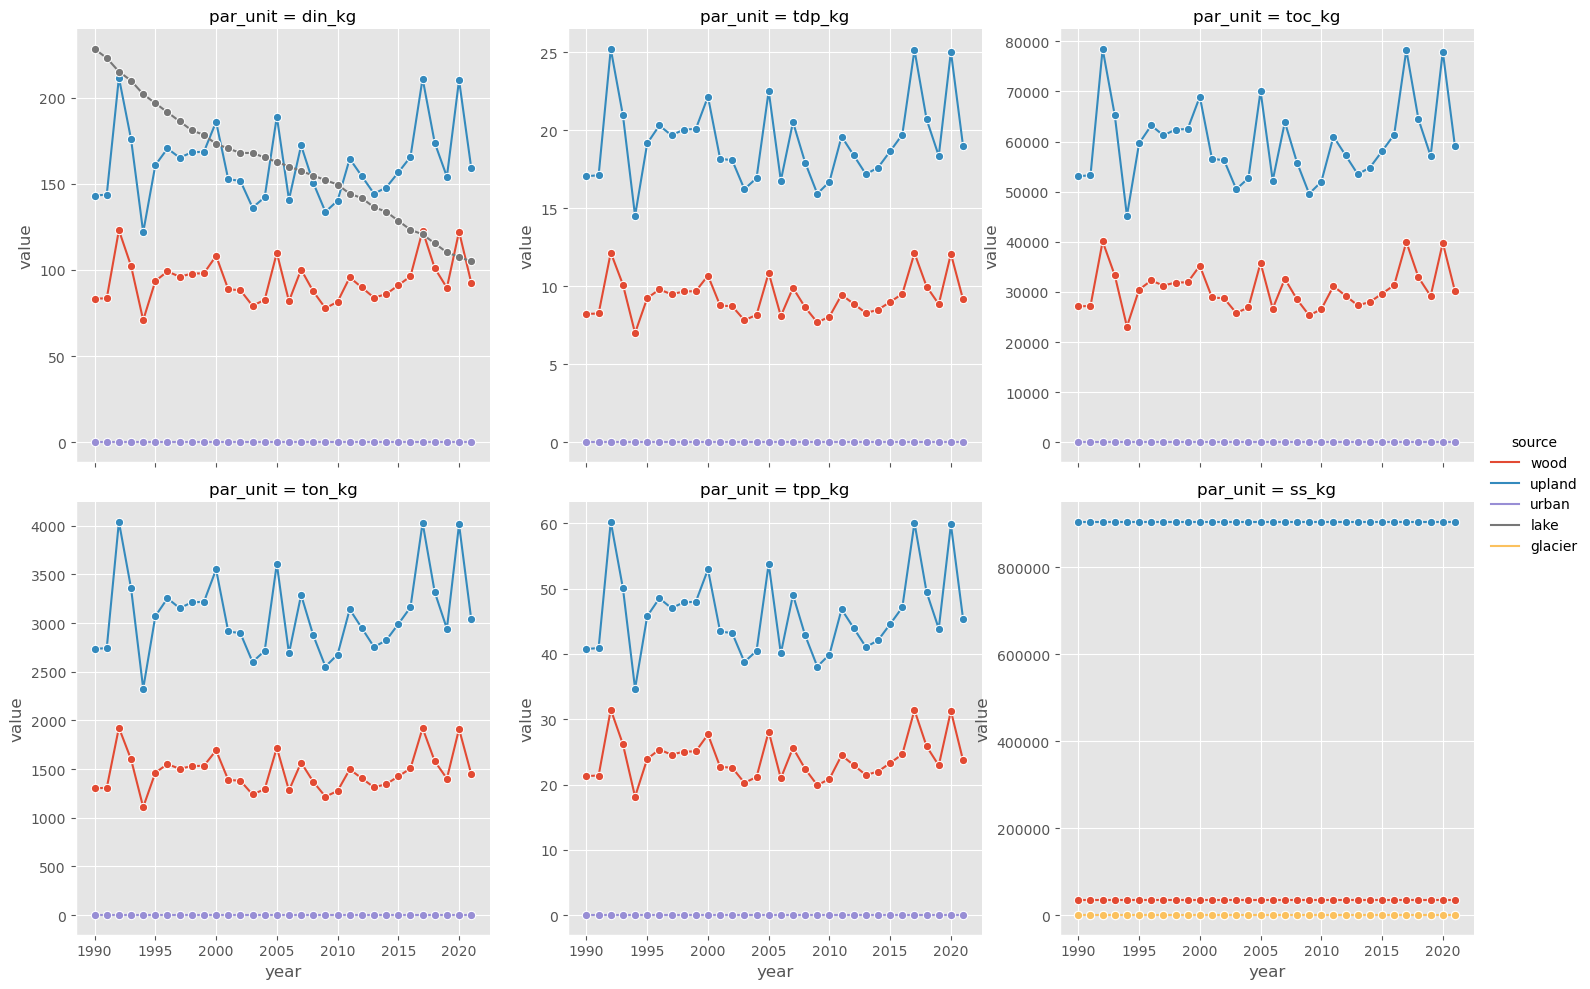

In [10]:
# Year to use for getting data from old model
comp_year = 2020

# Regine of interest
reg_id = "234.GBB1Z"

# Compare old vs. new
comp_df = compare_regine_series(reg_id, df, comp_year)

# Time series for new
reg_df = summarise_regine_series(reg_id, df, comp_year, log_y=False)

#### 2.2.4. A forested catchment in Sørlandet

Again, the `woodland` and `upland` coefficients in the new model are a little lower than in TEOTIL2, but natural fluxes are nevertheless comparable. For urban, the old model uses coarser land cover data that does not identify any urban areas within this catchment, whereas AR50 identifies a very small `urban` area (which in this case is the shooting range above Flakk near Birkeland, which is not really urban).

value           
model                       new        old
source  par_unit                          
natdiff tot-n_tonnes  18.967505  28.579131
        tot-p_tonnes   0.225941   0.337269
urban   tot-n_tonnes   0.043953   0.000000
        tot-p_tonnes   0.004395   0.000000

value
par_unit source                
din_kg   lake       2008.789856
         upland      229.131392
         urban        19.626395
         wood       3544.907064
ss_kg    glacier       0.000000
         upland    70254.494441
         urban      1401.885346
         wood      80432.420179
tdp_kg   upland        3.459591
         urban         2.102828
         wood         43.568690
toc_kg   upland    20225.302913
         urban       154.207388
         wood     324784.781250
ton_kg   upland      619.266841
         urban        15.420739
         wood       9696.013957
tpp_kg   upland        6.653060
         urban         1.401885
         wood        126.745280

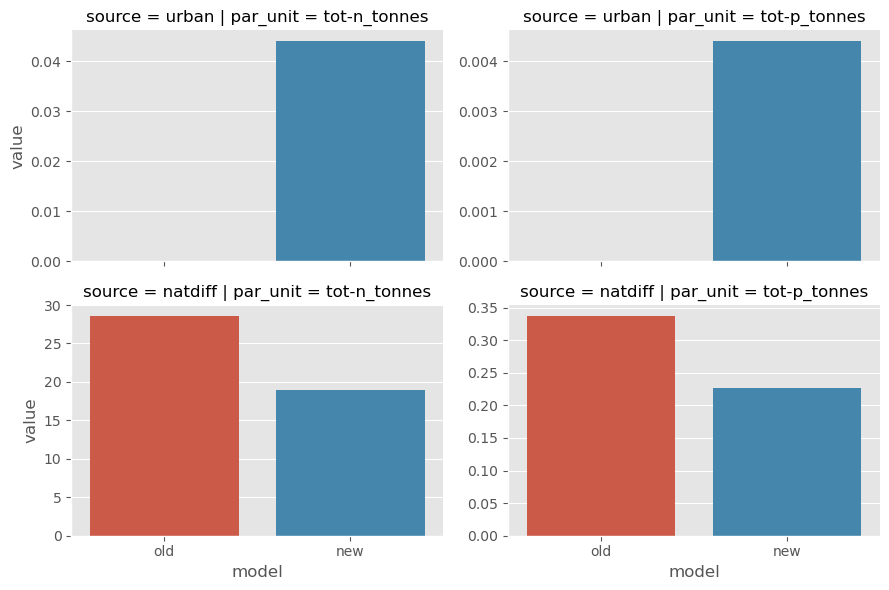

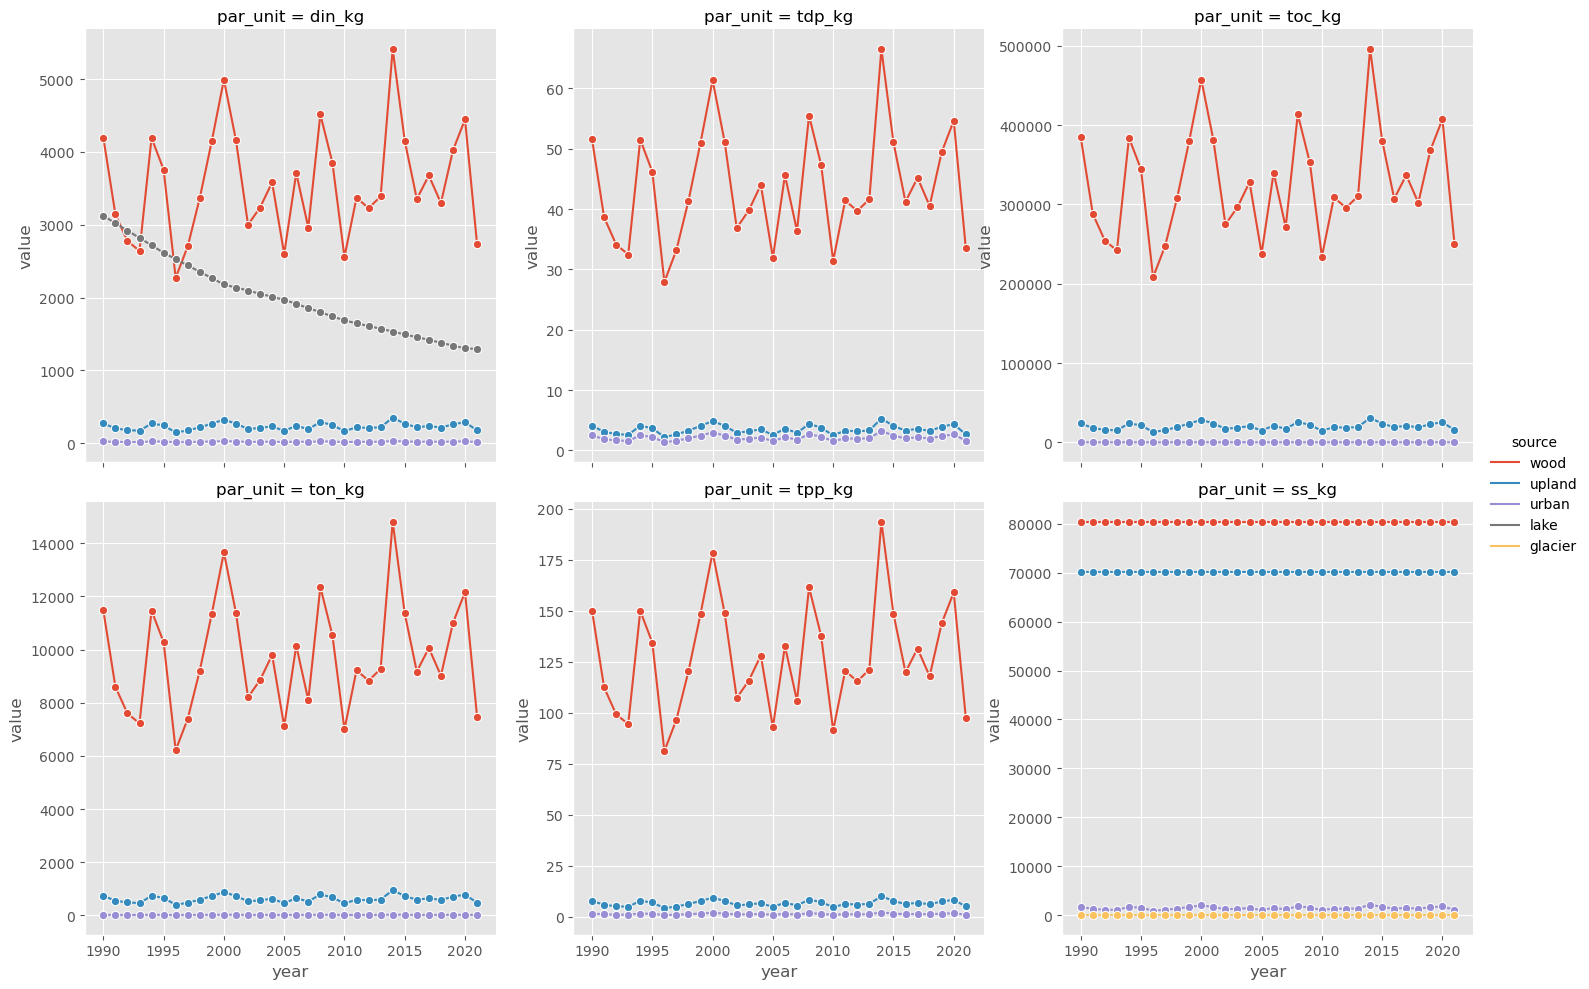

In [11]:
# Year to use for getting data from old model
comp_year = 2020

# Regine of interest
reg_id = "020.AZ"

# Compare old vs. new
comp_df = compare_regine_series(reg_id, df, comp_year)

# Time series for new
reg_df = summarise_regine_series(reg_id, df, comp_year, log_y=False)

## 3. Summary

 * The new model inputs for non-agricultural diffuse inputs are superficially plausible, and show the expected spatial and temporal patterns
 * Results are broadly compatible with those from TEOTIL2, with the exception that:
   * The new model estimates much higher inputs from urban area than the old one. As mentioned in the notebook for T2-7c, I am currently using the highest set of urban coefficients from Åstebøl et al. (i.e. the values for "tett by", rather than "åpen by"). Based on the preliminary comparison here, it may be better to use values for "åpen by" instead, but I'll leave this decision until I've compared the new model output to measured fluxes
   * The new coefficients for `woodland` and `upland` are generally lower than those used in the old model. This is especially true in South-western Norway (and also in the far north and south of the country, but these differences are less noticeable). Coefficients for South-eastern Norway seem very similar to those in TEOTIL2
   * The coefficients from Bogen (1996) predict very high sediment yields. It would be nice to find additional data to support these coefficients, as I'm not sure whether they are reasonable. I expect retention of sediment in lakes to be high, so perhaps the overall simulated fluxes will be reasonable once retention is taken into account. This should be revisited once the output from the new model can be compared to measured fluxes